# Creating Low-Poly Art From Photo

**Idea:** use subset of edge pixels as vertices for the tessellation  

**Steps:** 
* load packages and image
* apply Laplace or Sobel filter for edge detection
* choose a subset of edge pixels as vertices for the triangulation
* generate the tessellation using the VoronoiDelaunay package
* set the colour of a triangle as the mean of the pixel values of the input image lying within the triangle and create the new image:
    * go through all the pixels and find the triangle they are located in; use a dictionary to store all pixel coordinates that lie in a triangle
    * go through all triangles, compute the mean of all (input) pixel values in that triangle and set all (output) pixel values in the triangle to be the mean


In [1]:
# Load packages
using Images
using ImageFiltering
using VoronoiDelaunay
using FileIO
using ImageMagick
using Random
using GeometricalPredicates
using Gadfly
using Statistics;

In [2]:
# Load picture and adjust size
img = load("Bilder/MIRI0095.JPG")
(h, w) = size(img)
img = img[1:8:h,1:8:w]
(h, w) = size(img)

(648, 486)

Apply the Laplace filter? I decided for the Sobel filter instead, because there are less points in the fine textures in the foreground (the fabric) and the rougher (blurred) edges in the background are detected, which looks a bit nicer.

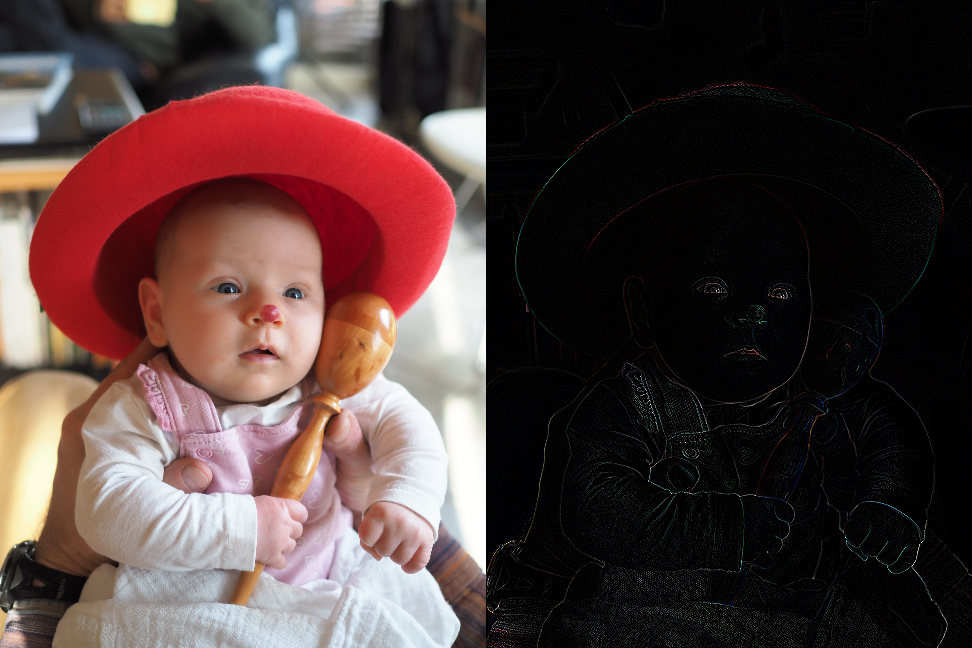

In [3]:
# Apply Laplace filter?
Edges = imfilter(img, Kernel.Laplacian())
[img Edges]

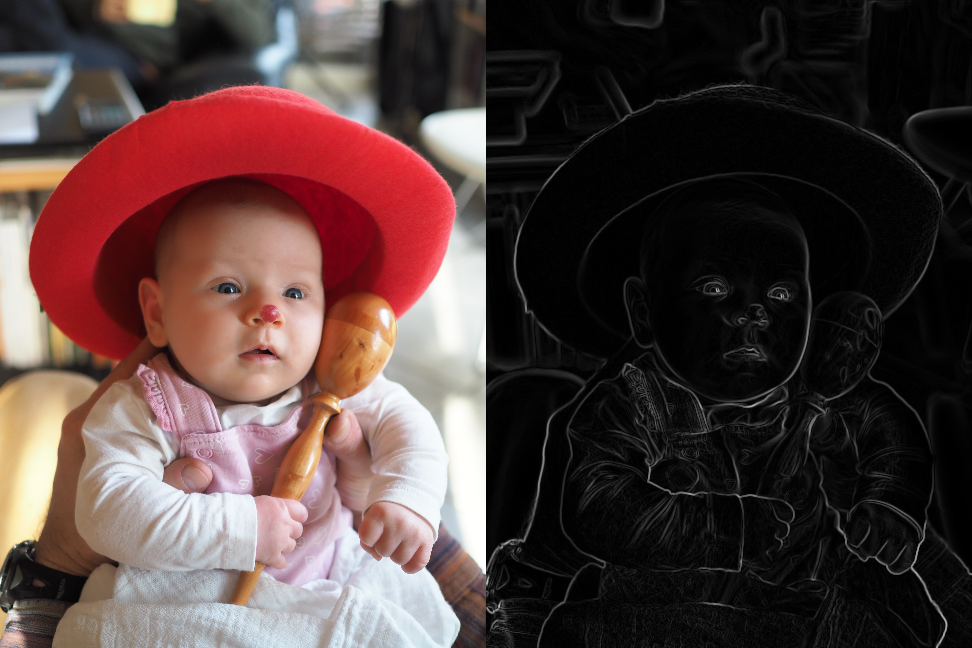

In [4]:
# Apply Sobel filter!
grayimg = Gray.(img)
sobel_x = centered([ 1 0 -1; 2 0 -2; 1 0 -1 ]);
sobel_y = sobel_x';
# Scale the kernel values to reduce the effect.
sobel_x = sobel_x / 4.0;
sobel_y = sobel_y / 4.0;
Gx = imfilter(grayimg,sobel_x);
Gy = imfilter(grayimg,sobel_y);
Edges = similar(Gx)
Edges .= sqrt.( Gx.^2 .+ Gy.^2 )
[img Edges]

In [5]:
# Find all edge coordinates whose gray values are larger than some threshold, here 0.02.
EdgeCoordinates = findall( x -> x>0.02, Real.(Gray.(Edges)) );
# Take a subset of this---5% turned out to be fine-grained enough to reproduce the fine details like the eyes, while still showing sufficiently large triangles.
VerticesCartesianIndex = randsubseq(EdgeCoordinates,0.02);
# Some cosmetics? Blend out towards the verge of the image, take out some of the coordinates at the verge of the image? Not today.
#VerticesCloseToBoundary = VerticesCartesianIndex[ findall( x -> x[1]<0.06*h || x[2]<0.06*w || x[1]>0.94*h || x[2]>0.94*w, VerticesCartesianIndex ) ]
#VerticesCartesianIndex = setdiff( VerticesCartesianIndex, randsubseq(VerticesCloseToBoundary,0.6) )
#VerticesCloseToBoundary = VerticesCartesianIndex[ findall( x -> x[1]<0.04*h || x[2]<0.04*w || x[1]>0.96*h || x[2]>0.96*w, VerticesCartesianIndex ) ]
#VerticesCartesianIndex = setdiff( VerticesCartesianIndex, randsubseq(VerticesCloseToBoundary,0.6) )
# Adding some random points? I decided against this. It does not improve the picture.
# RandomCoordinates = CartesianIndex.( rand( 1:h, 100 ), rand( 1:w, 100 ) )
# VerticesCartesianIndex = union( VerticesCartesianIndex, RandomCoordinates )
summary(VerticesCartesianIndex)

"2895-element Array{CartesianIndex{2},1}"

In [6]:
# Convert Vertices from CartesianIndex to Point2D for the tessellation algorithm.
l = Int64.(length(VerticesCartesianIndex))
VerticesPoints = Array{Point2D,1}(undef,l)
stepsize = min( 1.0/h, 1.0/w )
for index in eachindex(VerticesCartesianIndex)
    (i,j) = Tuple(VerticesCartesianIndex[index])
    VerticesPoints[index] = Point( 0.0+(j-0.5)*stepsize, 1.0-(i-0.5)*stepsize )
end
# Add some vertices outside the picture, so that the triangulation covers the whole image. 
# At the corners of the image...
#push!(Vertices, Point(0.0,1.0))
#push!(Vertices, Point(0.0+w*stepsize,1.0))
#push!(Vertices, Point(0.0+w*stepsize,1.0-h*stepsize))
#push!(Vertices, Point(0.0,1.0-h*stepsize))
# ... or somewhere further out, for a smoother look at the verge of the image? Further out!
push!(VerticesPoints, Point(-0.1,1.1))
push!(VerticesPoints, Point(0.1+w*stepsize,1.1))
push!(VerticesPoints, Point(0.1+w*stepsize,0.9-h*stepsize))
push!(VerticesPoints, Point(-0.1,0.9-h*stepsize))
push!(VerticesPoints, Point(-0.3,1.0-h*stepsize/2.0))
push!(VerticesPoints, Point(0.3+w*stepsize,1.0-h*stepsize/2.0))
push!(VerticesPoints, Point(w*stepsize/2.0,1.3))
push!(VerticesPoints, Point(w*stepsize/2.0,0.7-h*stepsize))
summary(VerticesPoints)

"2903-element Array{Point2D,1}"

In [8]:
# Compute the Delaunay tessellation.
@time tess = DelaunayTessellation( VerticesPoints );

  0.235039 seconds (1.62 M allocations: 63.302 MiB, 10.78% gc time)


In [9]:
# Plot the tessellation.
xyEdges = getplotxy(delaunayedges(tess))
l1 = layer( x=getx.(VerticesPoints), y=gety.(VerticesPoints), color=[colorant"orange"], Geom.point )
l2 = layer( x=xyEdges[1], y=xyEdges[2], Geom.path )
set_default_plot_size(20cm,20cm)
plot( l1, l2, Coord.cartesian(fixed=true, xmin=-0.3, xmax=0.3+w*stepsize, ymin=0.7-h*stepsize, ymax=1.3) )

For each pixel, find the triangle the pixel lies in and gather all pixels corresponding to a triangle in a dictionary. The dictionary contains a list of cartesian indices (value) for every triangle (key). This is a **slow and simple algorithm** that walks through every triangle (inside function locateTriangle). See below for a faster implementation.

In [10]:
# Function that returns the triangle a pixel lies in.
function locateTriangle(trigs, p)
    for t in trigs
        a = ((t._b._y-t._c._y)*(p._x-t._c._x)+(t._c._x-t._b._x)*(p._y-t._c._y))/((t._b._y-t._c._y)*(t._a._x-t._c._x)+(t._c._x-t._b._x)*(t._a._y-t._c._y))
        b = ((t._c._y-t._a._y)*(p._x-t._c._x)+(t._a._x-t._c._x)*(p._y-t._c._y))/((t._b._y-t._c._y)*(t._a._x-t._c._x)+(t._c._x-t._b._x)*(t._a._y-t._c._y))
        c = 1-a-b
        if 0<=a<=1 && 0<=b<=1 && 0<=c<=1
            return t
            break
        end
    end
end

locateTriangle (generic function with 1 method)

In [12]:
@time begin
PixelsInTriangle = Dict()
Triangles = delaunayTriangles(tess._trigs)
for i in 1:h
    for j in 1:w
        p = Point( 0.0+(j-0.5)*stepsize, 1.0-(i-0.5)*stepsize )
        t = locateTriangle( Triangles, Point( 0.0+(j-0.5)*stepsize, 1.0-(i-0.5)*stepsize ) )
        if haskey(PixelsInTriangle, t)
            push!( PixelsInTriangle[t], CartesianIndex(i,j) )
        else
            PixelsInTriangle[t] = [CartesianIndex(i,j)]
        end
    end
end
end

 14.414923 seconds (5.39 M allocations: 120.909 MiB, 0.16% gc time)


**faster algorithm** that makes use of 
1. the fact that neighbouring pixels are likely to lie in the same triangle, and 
2. the knowledge of the neighbouring triangles.

Instead of walking through all triangles, when processing a new pixel, the algorithm first checks whether the pixel lies in the triangle of a previous pixel. If that is the case, save the triangle-pixel correlation. If not, the barycentric coordinates tell you which direction to go, and the indices of the neighbouring triangles (saved in the triangle struct) let you test a triangle closer to the actual solution. 

The algorithm temporarily saves the triangle index of the last pixel in the same row, $\blacktriangleright\_\text{index}$, 
and the index of the triangle from the beginning of the row, $\blacktriangledown\_\text{index}$. 

The computation of the barycentric coordinates is numerically unstable and may result in inconclusive behaviour. In this simplified setup, these pixels are simply discarded (and set to the old pixel value). The slow algorithm has the same problem (and sets random pixel values).

In [13]:
function barycentricCoordinates(△, p)
    α = ((△._b._y-△._c._y)*(p._x-△._c._x)+(△._c._x-△._b._x)*(p._y-△._c._y))/((△._b._y-△._c._y)*(△._a._x-△._c._x)+(△._c._x-△._b._x)*(△._a._y-△._c._y))
    β = ((△._c._y-△._a._y)*(p._x-△._c._x)+(△._a._x-△._c._x)*(p._y-△._c._y))/((△._b._y-△._c._y)*(△._a._x-△._c._x)+(△._c._x-△._b._x)*(△._a._y-△._c._y))
    γ = 1 - α - β
    return α, β, γ 
end

indexOfTriangle( △ ) = filter( x -> tess._trigs[x] == △, tess._trigs[△.n[1]].n )[1]

indexOfTriangle (generic function with 1 method)

In [15]:
@time begin
PixelsInTriangle = Dict()
Triangles = delaunayTriangles(tess._trigs)
# initialize starting triangle = triangle of first pixel
▼_index = indexOfTriangle( locateTriangle( Triangles, Point( 0.5*stepsize, 1.0-0.5*stepsize ) ) )
for i in 1:h
    ▶_index = ▼_index
    for j in 1:w
        △_index = ▶_index
        △ = tess._trigs[△_index]
        p = Point( 0.0+(j-0.5)*stepsize, 1.0-(i-0.5)*stepsize )
        α, β, γ = barycentricCoordinates( △, p )
        visited = []
        while !( 0<=α<=1 && 0<=β<=1 && 0<=γ<=1 )
            # due to finite precision arithmetic, if a point is on the border of a triangle, we may go back and forth between triangles
            # I simply dismiss the pixel, since it is not easily spotted in the final picture anyways.
            # They are also dismissed in the slow implementation. 
            if △_index ∈ visited 
                △ = DelaunayTriangle(p, p, p, (▶_index,▶_index,▶_index), (1,1,1))
                △_index = ▶_index
                break
            end
            if α<0
                push!( visited, △_index )
                △ = tess._trigs[△.n[1]]
                △_index = indexOfTriangle( △ )
                α, β, γ = barycentricCoordinates( △, p )
                continue
            end
            if β<0
                push!( visited, △_index )
                △ = tess._trigs[△.n[2]]
                △_index = indexOfTriangle( △ )
                α, β, γ = barycentricCoordinates( △, p )
                continue
            end
            if γ<0
                push!( visited, △_index ) 
                △ = tess._trigs[△.n[3]]
                △_index = indexOfTriangle( △ )
                α, β, γ = barycentricCoordinates( △, p )
                continue
            end
        end
        if haskey( PixelsInTriangle, △ )
            push!( PixelsInTriangle[△], CartesianIndex(i,j) )
        else
            PixelsInTriangle[△] = [ CartesianIndex(i,j) ]
        end
        if j == 1
            ▼_index = △_index
        else
            ▶_index = △_index
        end
    end
end
end

  1.175217 seconds (12.03 M allocations: 273.050 MiB, 4.25% gc time)


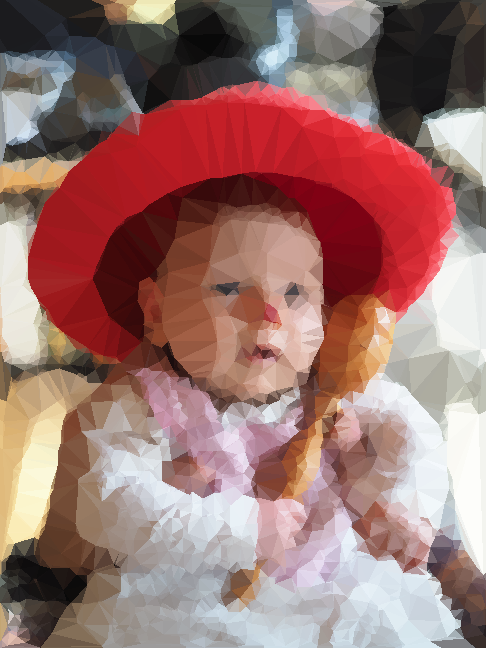

In [16]:
# Create the new image. Set pixel values as the mean of the input pixel values in the triangle.
new_img = similar(img)
for △ in collect(keys(PixelsInTriangle))
    new_img[ PixelsInTriangle[△] ] .= mean( img[ PixelsInTriangle[△] ] )
end
new_img